# Toy Examples

In [1]:
from typing import Optional

from fastcluster import complete as max_linkage
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, fcluster
from scipy.integrate import trapezoid

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

## Figure 1 toy surfaces

In [2]:
def linear(X: np.ndarray):
    return np.prod(X, axis=1)


def radial(X: np.ndarray):
    return np.sum(np.square(X - X.mean(0)), -1)


def checkerboard(
    X: np.ndarray, anchors: np.ndarray, radius: Optional[float] = None, square: bool = True
):
    D = X[:, None] - anchors[None, :]   # n x c x d
    d = np.sqrt(np.sum(np.square(D), -1))   # n x c

    if radius is None:
        y = d.min(-1)
    elif square:
        y = (np.abs(D) < radius).all(-1).any(-1)
    else:
        y = (d < radius).any(-1)

    return 1.0 * y

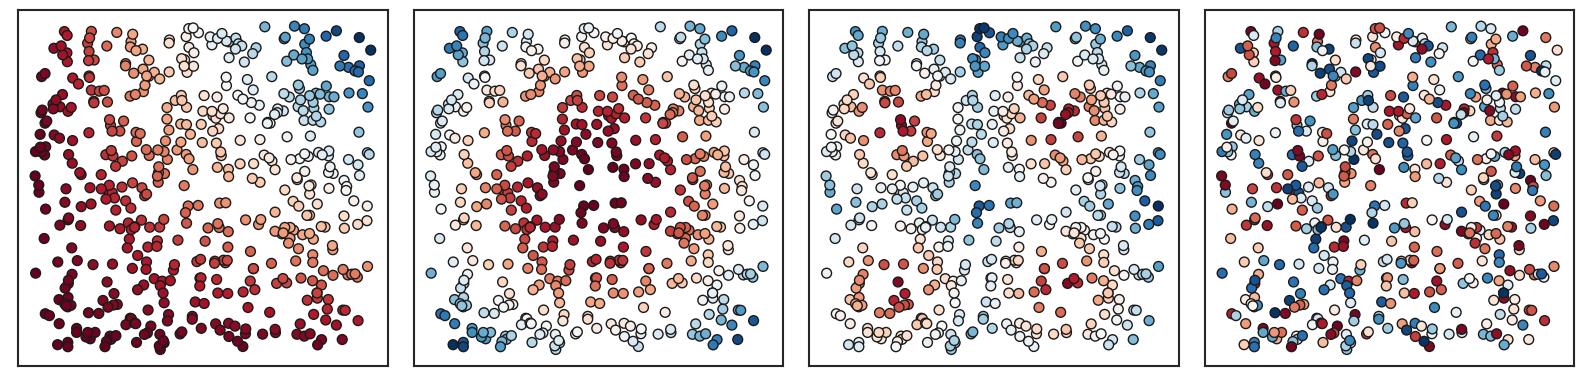

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 4))
ax = axs[0]

rg = np.random.default_rng(181)
X = rg.uniform(size=(500, 2))
n_anchors = 2

z = linear(X)
axs[0].scatter(X[:, 0], X[:, 1], 50, z, 'o', "RdBu", edgecolors='k')

z = radial(X)
axs[1].scatter(X[:, 0], X[:, 1], 50, z, 'o', "RdBu", edgecolors='k')

x = [0.2, 0.7]
anchors = np.array([(xi, yi) for xi in x for yi in x])
z = (checkerboard(X, anchors, square=True))
axs[2].scatter(X[:, 0], X[:, 1], 50, z, 'o', "RdBu", edgecolors='k')

z = rg.uniform(size=len(X))
axs[3].scatter(X[:, 0], X[:, 1], 50, z, 'o', "RdBu", edgecolors='k')

for ax in axs:
    ax.set_yticks([])
    ax.set_xticks([])

fig.tight_layout()

In [7]:
fig.savefig("../results/figures/toy/surfaces.pdf", bbox_inches="tight")

## Figure 2 (Dendrogram example)

In [4]:
def calc_rogi(D: np.ndarray, y: np.ndarray, min_dt: Optional[float] = 0.01):
    Z = max_linkage(D)
    thresholds_all = Z[:, 2]
    
    if min_dt is not None:
        thresholds = []
        steps = []
        t_prev = -1
        for i, t in enumerate(thresholds_all):
            if t < t_prev + min_dt:
                continue

            thresholds.append(t)
            steps.append(i)
            t_prev = t
    else:
        thresholds = thresholds_all
        steps = list(range(len(thresholds_all)))

    n_clusters = []
    cg_sds = []
    for t in thresholds:
        cluster_ids = fcluster(Z, t, "distance")
        clusters = set(cluster_ids)

        y_cg = np.copy(y)
        for i in clusters:
            mask = cluster_ids == i
            y_cg[mask] = y[mask].mean()
            
        n_clusters.append(len(clusters))
        cg_sds.append(y_cg.std())
    
    cg_sds = np.array([y.std(), *cg_sds, 0])
    disp_loss = 2 * (cg_sds[0] - cg_sds)

    thresholds = np.array([0, *thresholds, 1])
    n_clusters = np.array([len(y), *n_clusters, 1])
    f_cg = np.array([0, *steps, len(Z)]) / len(Z)

    return disp_loss, thresholds, n_clusters, f_cg


def plot_auc(x, y, label, ax: plt.Axes = None):
    ax = ax or plt.gca()

    lines = ax.plot(x, y, '-', label=label, alpha=0.9)
    pc = ax.fill_between(x, 0, y, alpha=0.1, label='_x')
    
    return lines[0], trapezoid(y, x)

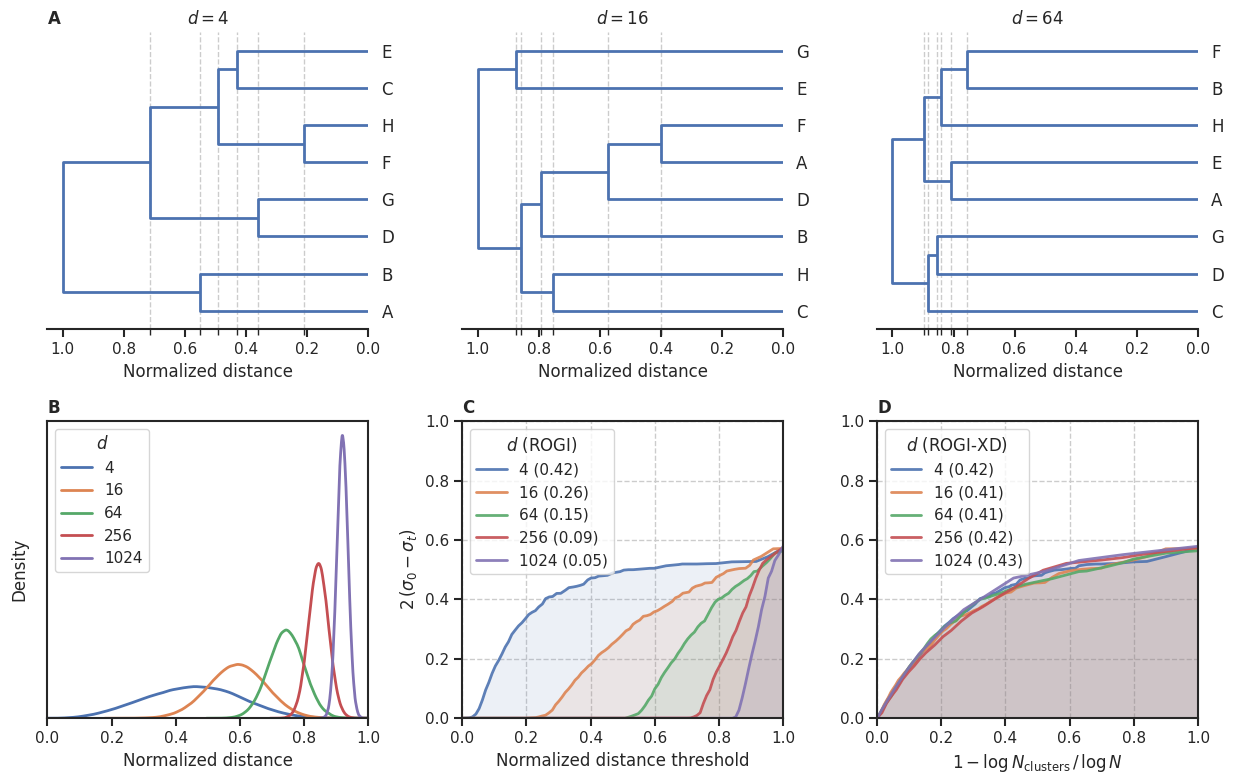

In [5]:
fig, l2ax = plt.subplot_mosaic(
    [
        ['a1', 'a2', 'a3'],
        ['b', 'c', 'd']
    ],
    figsize=(3 * 4 + 0.5, 2 * 4)
)

RG = np.random.default_rng(11)
dims = [4, 16, 64]
labels = "ABCDEFGH"
N = len(labels)

for d, l in zip(dims, ['a1', 'a2', 'a3']):
    ax = l2ax[l]
    X = RG.uniform(size=(N, d))
    D = np.sqrt(np.sum(np.square(X[None, :, :] - X[:, None, :]), -1))
    D = D[np.triu_indices(N, 1)]
    D /= D.max()
    Z = max_linkage(D)
    R = dendrogram(Z, color_threshold=0, labels="ABCDEFGH", orientation="left", ax=ax)

    ticks = np.sort([Dk[1] for Dk in R['dcoord']])#[::-1]
    # ticks = [0, *ticks]
    # labels = N - np.arange(len(ticks))
    
    ax.set_xticks(ticks, minor=True)
    ax.set_xlabel("Normalized distance")
    ax.spines[['left', 'right', 'top']].set_visible(False)
    ax.grid(False)
    ax.grid(True, 'minor', axis='x')

    ax.set_title(rf"$d={d}$", size="medium")

dims = 4 ** np.arange(1, 6)
RG = np.random.default_rng(24)
N = 1000

handles_aucs_1 = []
handles_aucs_2 = []
for d in dims:
    X = RG.uniform(size=(N, d))
    y = RG.uniform(size=N)
    # y = MinMaxScaler().fit_transform(np.square(X - X.mean(0)).sum(-1, keepdims=True))[:, 0]

    D = np.sqrt(np.sum(np.square(X[None, :, :] - X[:, None, :]), -1))
    D = D[np.triu_indices(N, 1)]
    D /= D.max()
    disp_loss, thresholds, n_clusters, z = calc_rogi(D, y, 0.01)
    log_cr = 1 - np.log(n_clusters) / np.log(n_clusters[0])

    sns.kdeplot(x=D, ax=l2ax['b'], label=d, lw=2)
    handle, auc = plot_auc(thresholds, disp_loss, d, l2ax['c'])
    handles_aucs_1.append((handle, auc))
    handle, auc = plot_auc(log_cr, disp_loss, d, l2ax['d'])
    handles_aucs_2.append((handle, auc))

l2ax['a1'].set_title("A", fontweight="bold", loc="left")

l2ax['b'].set_title("B", fontweight="bold", loc="left")
l2ax['b'].legend(title=r"$d$")
l2ax['b'].set_yticks([])
l2ax['b'].set_xlim(0, 1)
l2ax['b'].grid(False)
l2ax['b'].set_xlabel("Normalized distance")
l2ax['b'].set_ylabel("Density", labelpad=8)

handles_c, aucs_c = zip(*handles_aucs_1)
labels_c = [f"{h.get_label()} ({auc:0.2f})" for h, auc in zip(handles_c, aucs_c)]
l2ax['c'].set_title("C", fontweight="bold", loc="left")
l2ax['c'].legend(handles_c, labels_c, title=r"$d$ (ROGI)", loc='upper left')
l2ax['c'].set_xlabel("Normalized distance threshold")
l2ax['c'].set_ylabel(r"$2\,(\sigma_0 - \sigma_t)$")
l2ax['c'].sharey(l2ax['d'])

handles_d, aucs_d = zip(*handles_aucs_2)
labels_d = [f"{h.get_label()} ({auc:0.2f})" for h, auc in zip(handles_d, aucs_d)]
l2ax['d'].set_title("D", fontweight="bold", loc="left")
l2ax['d'].legend(handles_d, labels_d, title=r"$d$ (ROGI-XD)", loc='upper left')
l2ax['d'].set_xlabel(r"$1 - \log N_{\mathrm{clusters}}\,/\,\log N$")

for l in ["c", "d"]:
    ax = l2ax[l]
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)

fig.tight_layout()

In [54]:
fig.savefig("../results/figures/toy/dendrogram+toy.pdf", bbox_inches="tight")

## Alternative formulations

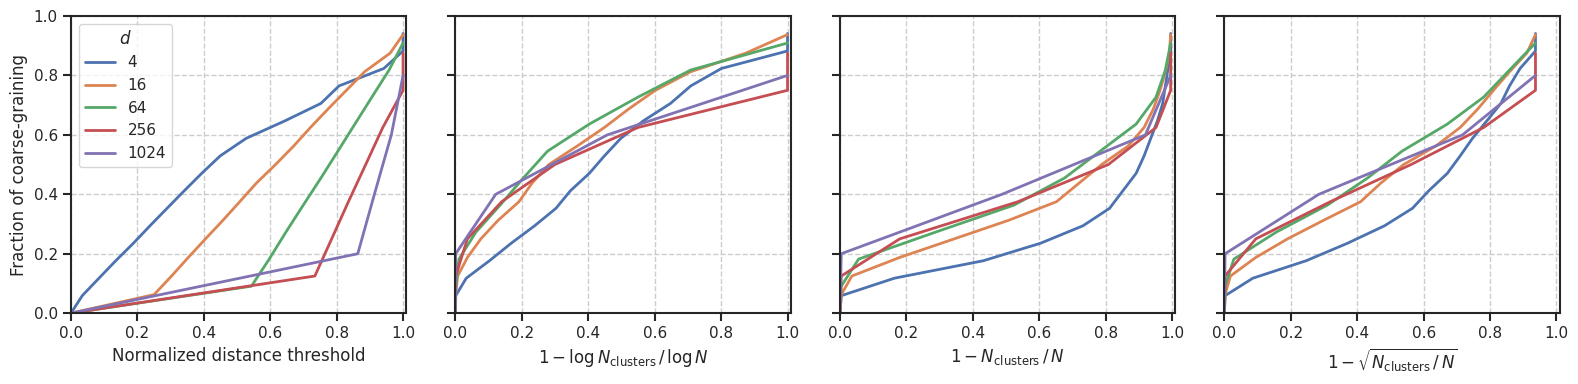

In [18]:
NCOLS = 4
dims = 4 ** np.arange(1, 6)
RG = np.random.default_rng(24)
N = 250

fig, axs = plt.subplots(1, NCOLS, figsize=(NCOLS * 4, 4), sharex=True, sharey=True,)

for d in dims:
    X = RG.uniform(size=(N, d))
    y = RG.uniform(size=N)
    D = np.sqrt(np.sum(np.square(X[None, :, :] - X[:, None, :]), -1))
    D = D[np.triu_indices(N, 1)]
    D /= D.max()
    
    _, thresholds, n_clusters, z = calc_rogi(D, y, 0.05)

    cr = 1 - n_clusters / n_clusters[0]
    log_cr = 1 - np.log(n_clusters) / np.log(n_clusters[0])
    sqrt_cr = 1 - np.sqrt(n_clusters / n_clusters[0])

    z = np.arange(len(thresholds)) / len(thresholds)

    axs[0].plot(thresholds, z, label=d)
    axs[1].plot(log_cr, z)
    axs[2].plot(cr, z)
    axs[3].plot(sqrt_cr, z)
    
# for ax, x in zip(axs, [thresholds, log_cr, cr, sqrt_cr]):
#     if x.max() < 1:
#         ax.axvline(x.max(), c='r', ls='--', alpha=0.7)

axs[0].set_xlabel("Normalized distance threshold")
axs[1].set_xlabel(r"$1 - \log N_{\mathrm{clusters}}\,/\,\log N$")
axs[2].set_xlabel(r"$1 - N_{\mathrm{clusters}}\,/\, N$")
axs[3].set_xlabel(r"$1 - \sqrt{N_{\mathrm{clusters}}\,/\,N}$")

axs[0].legend(title=r"$d$")
axs[0].set_ylabel("Fraction of coarse-graining")
axs[0].set_xlim(0, 1.01)
axs[0].set_ylim(0, 1)

fig.tight_layout()

In [64]:
fig.savefig("../results/figures/toy/reformulation_examples.pdf", bbox_inches="tight")

## Original ROGI paper Figure 1 recreation

c.f. Aldeghi et al. _JCIM_ **2022**, _62_ (19)

In [2]:
rg = np.random.default_rng(118999881999119725300)

X = rg.uniform(size=(150, 2))
z = rg.uniform(size=len(X))

D = np.sqrt(np.sum(np.square(X[None, :, :] - X[:, None, :]), -1))
D = D[np.triu_indices(D.shape[0], 1)]
D /= D.max()
Z = max_linkage(D)

THRESHOLDS = np.linspace(0, 1.00, 5)
cbar_kwargs = dict(cmap='plasma', vmin=z.min(), vmax=z.max())

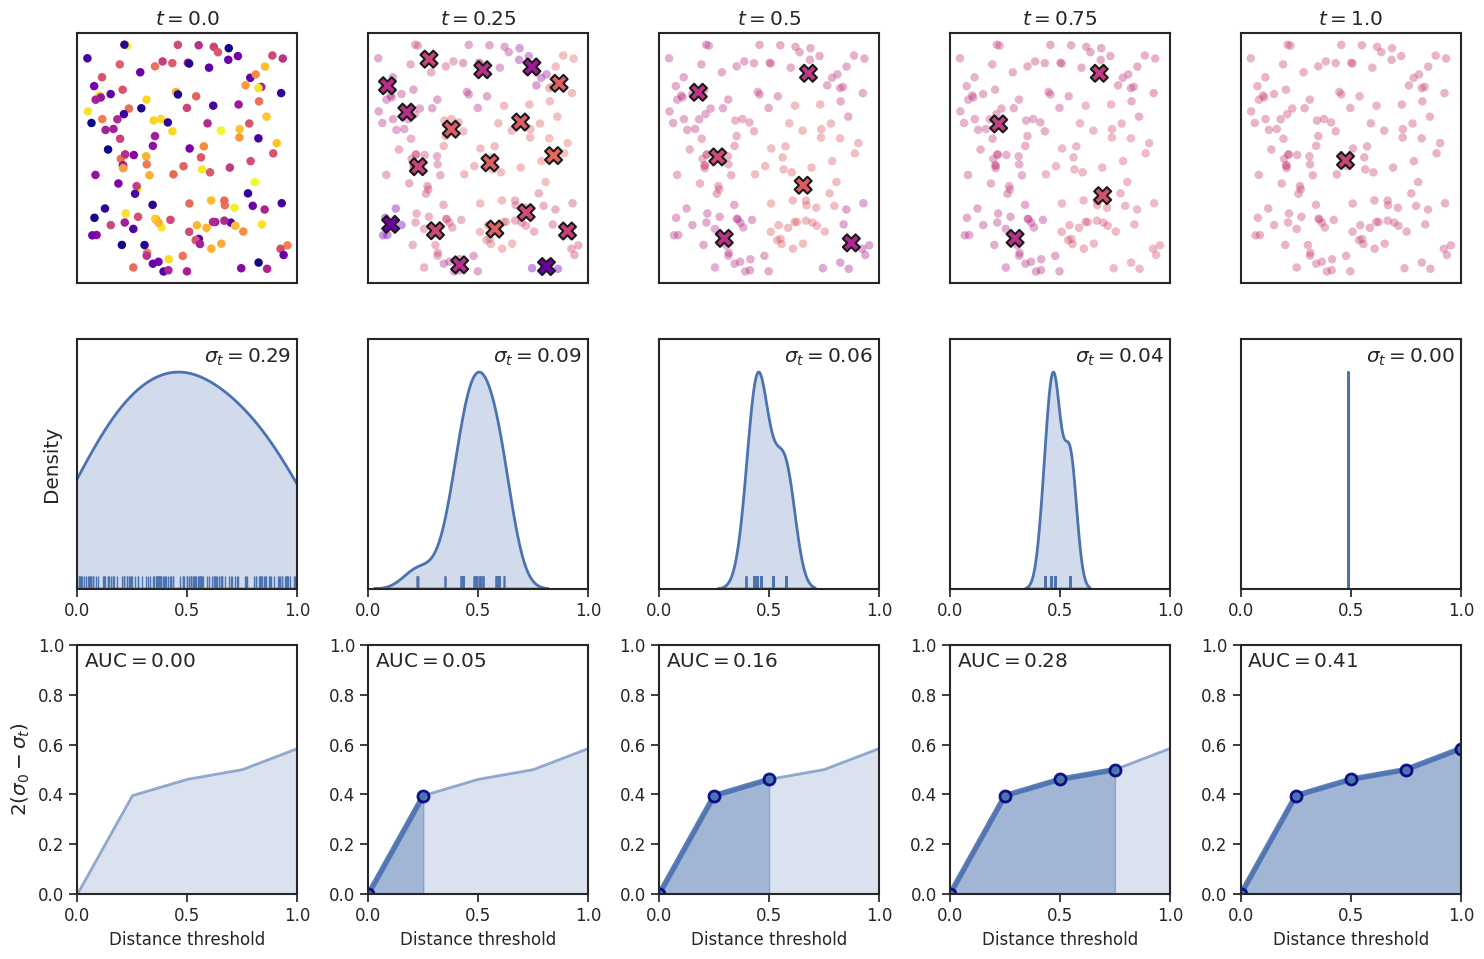

In [13]:
NROWS = 3
ncols = len(THRESHOLDS)
fig, axs = plt.subplots(NROWS, ncols, figsize=(3 * ncols, 3.25 * NROWS))

sds = []
for j in range(ncols):
    t = THRESHOLDS[j]

    cluster_ids = fcluster(Z, t, "distance")
    clusters = set(cluster_ids)

    y_cg = np.copy(z)
    X_centroids = []
    y_centroids = []
    for i in clusters:
        mask = cluster_ids == i
        y_ = z[mask].mean()
        x_ = X[mask].mean(0)

        X_centroids.append(x_)
        y_centroids.append(y_)
        y_cg[mask] = y_
    sds.append(y_cg.std())
    X_centroids = np.array(X_centroids)

    # SCATTER PLOTS
    ax = axs[0, j]
    if j == 0:
        ax.scatter(X[:, 0], X[:, 1], 150, y_cg, '.', edgecolor='None', **cbar_kwargs)
    else:
        ax.scatter(X[:, 0], X[:, 1], 150, y_cg, '.', edgecolor='None', **cbar_kwargs, alpha=0.4)
        ax.scatter(
            X_centroids[:, 0], X_centroids[:, 1], 150, y_centroids, 'X',
            **cbar_kwargs, edgecolor='k', linewidth=1.5
        )

    ax.set_title(rf"$t={t}$", fontsize="large")
    ax.set_yticks([])
    ax.set_xticks([])

    # DISTRIBUTION PLOTS
    ax = axs[1, j]
    sns.kdeplot(x=y_cg, fill=True, bw_method=0.7, lw=2, ax=ax)
    sns.rugplot(x=y_cg, height=0.05, ax=ax)
    ax.text(
        1 - 0.03, 1 - 0.03, rf"$\sigma_t={sds[j]:0.2f}$",
        ha="right", va="top", fontsize='large', transform=ax.transAxes
    )
    ax.set_yticks([])
    ax.set_xticks([0, 0.5, 1.])
    ax.grid(False)
    ax.set_xlim(0, 1)
    ax.tick_params(axis='x', which='major', direction='out', bottom=True, labelsize='medium')


# AUC PLOTS
sds = 2 * np.array(sds)
y_cg = sds[0] - sds
for j in range(ncols):
    ax: plt.Axes = axs[2, j]
    ax.plot(THRESHOLDS, y_cg, '-', lw=2, alpha=0.6)
    ax.fill_between(THRESHOLDS, 0, y_cg, alpha=0.2)

    auc = trapezoid(y_cg[:j + 1], THRESHOLDS[:j + 1])
    ax.text(
        0.03, 1 - 0.03, rf"$\mathrm{{AUC}}={auc:0.2f}$",
        ha="left", va="top", fontsize='large', transform=ax.transAxes
    )
    
    ax.set_xticks([0, 0.5, 1.])
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Distance threshold")
    ax.tick_params(
        axis='both', which='major', direction='out', bottom=True, left=True, labelsize='medium'
    )
    ax.grid(False)

for j in range(1, ncols):
    ax: plt.Axes = axs[2, j]
    ax.plot(THRESHOLDS[:j + 1], y_cg[:j + 1], 'bo-', lw=4, mec="navy", mew=2, ms=8, alpha=0.9)
    ax.fill_between(THRESHOLDS[:j + 1], 0, y_cg[:j + 1], color='b', alpha=0.4)
    

for j in range(1, ncols):
    axs[1, j-1].sharex(axs[1, j])
    axs[1, j].set_ylabel(None)

    axs[2, j-1].sharex(axs[2, j])
    axs[2, j-1].sharey(axs[2, j])
    axs[2, j].set_ylabel(None)

axs[1, 0].set_ylabel("Density", fontsize='large', labelpad=12)
axs[2, 0].set_ylabel(f"$2(\sigma_0 - \sigma_t)$", fontsize='large')
fig.tight_layout()

In [14]:
fig.savefig("../results/figures/toy/example.pdf", bbox_inches="tight")